In this Jupyter notebook, the data generated by the ALYA code will undergo post-processing.

The `ALYA_full_load_post_processing` script loads the complete dataset, requiring substantial RAM but allowing examination of every timestep, i.e., \( U(x,y,z,t) \). This the most detailed notebook, look at this one for more information.

The `ALYA_small_load_post_processing` script, on the other hand, is designed to load only the averaged data, i.e., \( \overline{U}(y) \), thereby reducing memory usage.

***

# 0. Introduction 

***

# Importation of useful libraries

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET  # For XML parsing
import pyvista as pv  # For reading and processing mesh data
import pandas as pd  # For data manipulation and DataFrame creation
import plotly.graph_objs as go # For 3D interactive plot
from plotly.subplots import make_subplots # For 3D interactive plot
from scipy.ndimage import label # Function to count the number of clusters 
import plotly.express as px # Package to color each clusters different Path # To have an absolute path
from pathlib import Path

print("Libraries imported successfully.")

Libraries imported successfully.


***

# 1. Data preparation 

***

# Loading Averaged Velocities

In [180]:
def load_data_and_give_average_velocity(directory):
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel_after_transient.pvd') # Not the full simulation, only the points after the transition state
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize arrays for accumulating data
    sum_u, sum_v, sum_w = 0, 0, 0
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        # Accumulate the velocity components
        u, v, w = mesh['VELOC'].T
        sum_u += u
        sum_v += v
        sum_w += w
        
        count += 1
        # print(f"Data from {path} loaded and velocity components added.") # If you want to check the files loaded
    
    # Calculate the average of the velocity components
    avg_u = sum_u / count
    avg_v = sum_v / count
    avg_w = sum_w / count
    
    # Get the spatial coordinates (assuming they are the same for all files)
    points = mesh.points  # x, y, z coordinates
    
    # Create a DataFrame with the averaged data
    data_t_avg = pd.DataFrame({
        'x': points[:, 0],
        'y': points[:, 1],
        'z': points[:, 2],
        'U_t_avg': avg_u,
        'V_t_avg': avg_v,
        'W_t_avg': avg_w
    })
    
    print(f"Total data sets processed: {count}")

    # Calculate mean over x and z for u, v, w 
    data_avg = data_t_avg.groupby('y').agg({
        'U_t_avg': ['mean'],
        'V_t_avg': ['mean'],
        'W_t_avg': ['mean']
    }).rename(columns={'mean': 'bar'}, level=1)
    data_avg.columns = ['U_bar', 'V_bar', 'W_bar']  # Clear column names
    
    return data_avg


In [181]:
# Old directory
#directory_path = Path('/Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk')

# Last directory
directory_path = Path('/Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Last_long_run_22_06/vtk')

# Small
#directory_path = Path('/Users/corentinprados/Documents/Stage_M2/Q_event_DRL_control/ALYA/longer_run_vtk')

mean_velocities = load_data_and_give_average_velocity(directory_path)

Total data sets processed: 212


# Loading RMS Velocities

In [182]:
def load_data_and_give_RMS_velocity(directory, mean_velocities):
    """
    This function loads PVTU files listed in a PVD file located in the given directory,
    calculates the RMS velocity components (u', v', w') across all timesteps, 
    and returns a DataFrame with the RMS velocity components averaged over x and z coordinates.
    
    Parameters:
    directory (str): Path to the directory containing the PVD and PVTU files.
    avg_velocities : Averaged velocity from load_data_and_give_average_velocity(directory)

    Returns:
    pd.DataFrame: DataFrame with RMS velocity components for each y-coordinate.
    """
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel_after_transient.pvd') # Not the full simulation, only the points after the transition state
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    
    # Extract PVTU file paths from the PVD file
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize arrays for accumulating squared velocity fluctuations
    sum_u2, sum_v2, sum_w2 = 0, 0, 0
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        
        # Extract velocity components
        u, v, w = mesh['VELOC'].T
        
        # Create a DataFrame with the instantaneous velocities and coordinates
        df = pd.DataFrame({
            'x': mesh.points[:, 0],
            'y': mesh.points[:, 1],
            'z': mesh.points[:, 2],
            'u': u,
            'v': v,
            'w': w
        })
        
        # Merge with data_avg to get the mean velocity for each y
        df = df.merge(mean_velocities, on='y')
        
        # Calculate the velocity fluctuations
        df['u_fluc'] = df['u'] - df['U_bar']
        df['v_fluc'] = df['v'] - df['V_bar']
        df['w_fluc'] = df['w'] - df['W_bar']
        
        # Accumulate the squared velocity fluctuations
        sum_u2 += df['u_fluc']**2
        sum_v2 += df['v_fluc']**2
        sum_w2 += df['w_fluc']**2
        
        count += 1
        # print(f"Data from {path} loaded and velocity components added.")  # Uncomment if you want to check the files loaded
    
    # Calculate the RMS of the velocity fluctuations
    rms_u = (sum_u2 / count)**0.5
    rms_v = (sum_v2 / count)**0.5
    rms_w = (sum_w2 / count)**0.5
    
    # Create a DataFrame with the RMS data
    data_t_rms = pd.DataFrame({
        'x': mesh.points[:, 0],
        'y': mesh.points[:, 1],
        'z': mesh.points[:, 2],
        'u_prime_t_rms': rms_u,
        'v_prime_t_rms': rms_v,
        'w_prime_t_rms': rms_w
    })
    
    print(f"Total data sets processed: {count}")

    # Calculate mean over x and z for u', v', w'
    rms_velocities = data_t_rms.groupby('y').agg({
        'u_prime_t_rms': 'mean',
        'v_prime_t_rms': 'mean',
        'w_prime_t_rms': 'mean'
    })
    
    # Rename columns for clarity
    rms_velocities.columns = ['u_prime', 'v_prime', 'w_prime']
    
    return rms_velocities


In [183]:
rms_velocities = load_data_and_give_RMS_velocity(directory_path, mean_velocities)

Total data sets processed: 212


# Check Plot

In [184]:
def plot_velocity_profiles(directory, mean_velocities, rms_velocities):
    
    # Plot U_bar
    plt.figure(figsize=(10, 6))
    plt.plot(mean_velocities.index, mean_velocities['U_bar'], label='U_bar', marker='o')
    plt.xlabel('y-coordinate')
    plt.ylabel('Mean Velocity (U_bar)')
    plt.title('Mean Velocity Profile (U_bar)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot u_prime
    plt.figure(figsize=(10, 6))
    plt.plot(rms_velocities.index, rms_velocities['u_prime'], label='u_prime', marker='o')
    plt.xlabel('y-coordinate')
    plt.ylabel('RMS Velocity Fluctuation (u_prime)')
    plt.title('RMS Velocity Fluctuation Profile (u_prime)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot v_prime
    plt.figure(figsize=(10, 6))
    plt.plot(rms_velocities.index, rms_velocities['v_prime'], label='v_prime')#, marker='o')
    plt.xlabel('y-coordinate')
    plt.ylabel('RMS Velocity Fluctuation (v_prime)')
    plt.title('RMS Velocity Fluctuation Profile (v_prime)')
    plt.legend()
    plt.grid(True)
    plt.show()

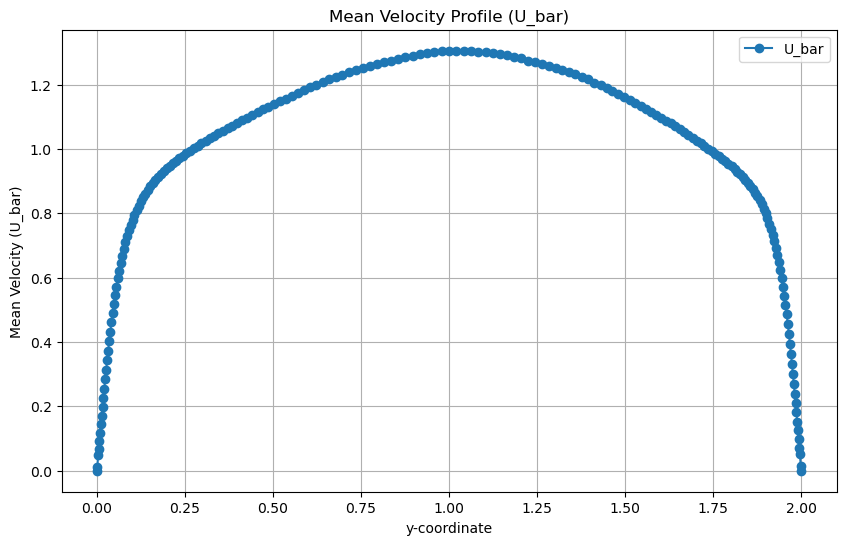

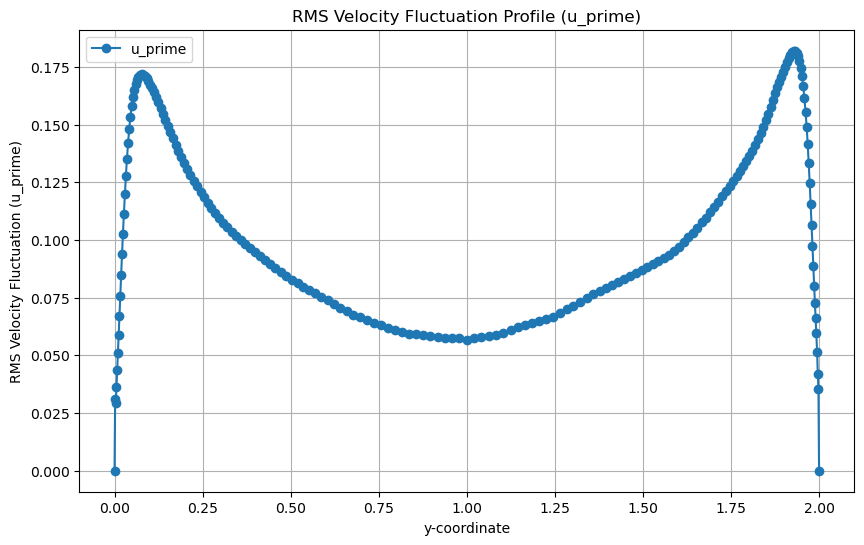

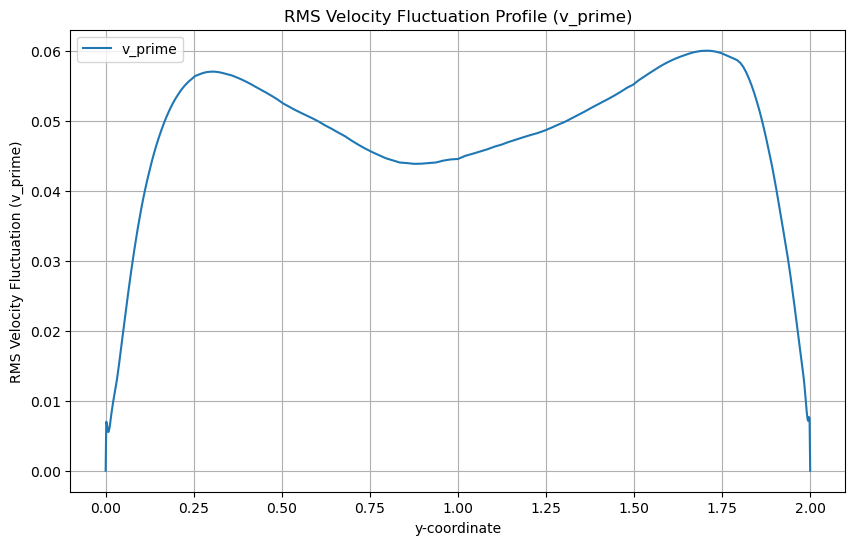

In [185]:
plot_velocity_profiles(directory_path, mean_velocities, rms_velocities)

For now, the shapes observed are consistent with those described in Jimenez's paper.

# Normalization

In [187]:
def normalize_data(mean_velocities, rms_velocities, nu):
    """
    Normalizes the velocity components and the y-coordinate in the mean_velocities and rms_velocities DataFrames using:
    u_tau = (Omega_bar * nu) ** 0.5 and y^+ = y * u_tau / nu
    
    Parameters:
    - mean_velocities (DataFrame): DataFrame with columns for y and
      time-averaged velocity components (U_bar, V_bar, W_bar).
    - rms_velocities (DataFrame): DataFrame with columns for y and
      RMS velocity components (u_prime, v_prime, w_prime).
    - nu (float): Kinematic viscosity of the fluid.
    
    Returns:
    - mean_velocities_normalized (DataFrame): DataFrame with the same columns as mean_velocities,
      where the velocity components and y-coordinate have been normalized.
    - rms_velocities_normalized (DataFrame): DataFrame with the same columns as rms_velocities,
      where the RMS velocity components and y-coordinate have been normalized.
    """
    # Calculate u_tau based on the mean velocities
    y = mean_velocities.index.values
    u_y = mean_velocities['U_bar']

    # Compute delta_u and delta_y at the minimum y (wall)
    delta_u_min = u_y.iloc[1] - u_y.iloc[0]
    delta_y_min = y[1] - y[0]
    Omega_bar_min = delta_u_min / delta_y_min

    # Compute delta_u and delta_y at the maximum y (wall)
    delta_u_max = u_y.iloc[-2] - u_y.iloc[-1]
    delta_y_max = y[-1] - y[-2]
    Omega_bar_max = delta_u_max / delta_y_max

    # Calculate u_tau at each wall and average them
    u_tau_min = (Omega_bar_min * nu) ** 0.5
    u_tau_max = (Omega_bar_max * nu) ** 0.5
    u_tau = (u_tau_min + u_tau_max) / 2
    #u_tau = 0.57231059E-01 # Test
    print(f"Calculated u_tau: {u_tau}")


    # Normalize the mean velocity components
    mean_velocities_normalized = mean_velocities.copy()
    mean_velocities_normalized['U_bar'] /= u_tau
    mean_velocities_normalized['V_bar'] /= u_tau
    mean_velocities_normalized['W_bar'] /= u_tau

    # Normalize the RMS velocity components
    rms_velocities_normalized = rms_velocities.copy()
    rms_velocities_normalized['u_prime'] /= u_tau
    rms_velocities_normalized['v_prime'] /= u_tau
    rms_velocities_normalized['w_prime'] /= u_tau

    # Normalize the y-coordinate in both DataFrames
    delta_tau = nu / u_tau
    #delta_tau = 0.005376316864804261# Test
    print(f"Calculated delta_tau: {delta_tau}")
    mean_velocities_normalized['y'] = mean_velocities_normalized.index / delta_tau
    rms_velocities_normalized['y'] = rms_velocities_normalized.index / delta_tau
    
    mean_velocities_normalized.set_index('y', inplace=True)
    rms_velocities_normalized.set_index('y', inplace=True)

    return mean_velocities_normalized, rms_velocities_normalized, u_tau, delta_tau


# Vérification de $Re_\tau$

In [188]:
nu = 0.0003546986585888876
mean_velocities_normalized, rms_velocities_normalized, u_tau, delta_tau = normalize_data(mean_velocities, rms_velocities, nu)


Calculated u_tau: 0.05067581975114417
Calculated delta_tau: 0.006999366962995781


In [189]:
h = 1
Re_tau = u_tau/nu*h
print(f"Calculated Re_tau: {Re_tau}")

Calculated Re_tau: 142.8700631481097


The first issue is that the $\text{Re}_\tau$ obtained from this calculation does not match the desired value 180. This discrepancy suggests either an error in the calculation or a need to adjust the parameters.

***

# 2. Validation of the simulation

***

To ensure the accuracy of our simulation, it will be benchmarked against the results obtained by Jiménez, which are available at [Jiménez's dataset](https://torroja.dmt.upm.es/channels/data/).

## Data Loading

Initial steps involve retrieving the Jiménez dataset for comparison.

In [11]:
def load_data_jimenez(file_path):
    """
    Loads simulation data from a specified file, aligning with the structure of data collected in the
    studies by Jiménez. This function assumes that the data file follows a specific column format,
    which needs to be predefined.

    Parameters:
    - file_path (str): The path to the data file containing simulation results by Jiménez.

    Returns:
    - DataFrame: Contains the loaded data with properly named columns for further analysis.

    Notes:
    - The data file is expected to use whitespace as a delimiter and to start with comment lines marked by '%'.
    - The file should not contain a header row; column names are assigned based on expected data structure.
    """

    # Define the column names as expected in the data file.
    # These names correspond to normalized measurements commonly used in turbulence studies:
    # - y/h: non-dimensional distance from the wall normalized by channel half-height
    # - y+: non-dimensional wall-normal coordinate, scaled using friction velocity and kinematic viscosity
    # - U+, u'+, v'+, w'+: normalized mean and fluctuating velocity components
    # - -Om_z+, om_x'+, om_y'+, om_z'+: normalized vorticity components
    # - uv'+, uw'+, vw'+: normalized Reynolds stress components
    # - pr'+, ps'+, psto'+, p': various normalized pressure fluctuations
    columns = [
        "y/h", "y+", "U+", "u'+", "v'+", "w'+", "-Om_z+", "om_x'+", "om_y'+", "om_z'+",
        "uv'+", "uw'+", "vw'+", "pr'+", "ps'+", "psto'+", "p'"
    ]

    # Load the data using pandas read_csv function. The function is configured to handle:
    # - delim_whitespace=True: Uses any whitespace string as a delimiter (common in many data files in scientific computing).
    # - comment='%': Ignore lines that start with '%' as these are comments in the data file.
    # - names=columns: Assigns the predefined column names to the DataFrame since the file lacks a header.
    df = pd.read_csv(file_path, delim_whitespace=True, comment='%', names=columns)
    
    return df



In [12]:
# File path to the Jiménez data set.
file_path = "Re180.prof.txt"
# Load the data and store it in a DataFrame for further use.
dataframe_jimenez = load_data_jimenez(file_path)


## Rewriting of ALYA Data

The data from Jiménez are presented for the normalized wall-normal distance $y/h$, ranging from 0 to 1, where 0 corresponds to the bottom wall and 1 represents the midpoint of the flow channel. To facilitate comparison, it is necessary to filter the dataset by retaining only the first half of the domain relative to $y$ and adjusting the data accordingly. The following code implements this filtering and shifting process:


In [192]:
def filter_data_by_y(data, y_min, y_max):
    """
    Filters rows from a DataFrame based on the y-coordinate falling within a specified range.

    Parameters:
    - data (DataFrame): The DataFrame to filter, which must include 'y' as an index.
    - y_min (float): The minimum y-coordinate value to include in the filter.
    - y_max (float): The maximum y-coordinate value to include in the filter.

    Returns:
    - filtered_data (DataFrame): A DataFrame containing only the rows where the 'y' value is
      between y_min and y_max, inclusive.
    """
    # Filter the DataFrame to include only the rows where the index 'y' is between y_min and y_max
    filtered_data = data[(data.index >= y_min) & (data.index <= y_max)]
    
    return filtered_data

In [193]:
# Application

y_min = 0.0/delta_tau  # Define the minimum y-coordinate
y_max = 1.0/delta_tau  # Define the maximum y-coordinate
filtered_mean_velocities_normalized = filter_data_by_y(mean_velocities_normalized, y_min, y_max)
filtered_rms_velocities_normalized = filter_data_by_y(rms_velocities_normalized, y_min, y_max)

Note that this interval includes the bottom wall at $y = 0$, (the top wall being at $y = 0$).

# Plots

In [13]:
u_tau_jimenez = 0.57231059E-01
delta_tau_jimenez = 0.005376316864804261

## Mean streamwise velocity field 

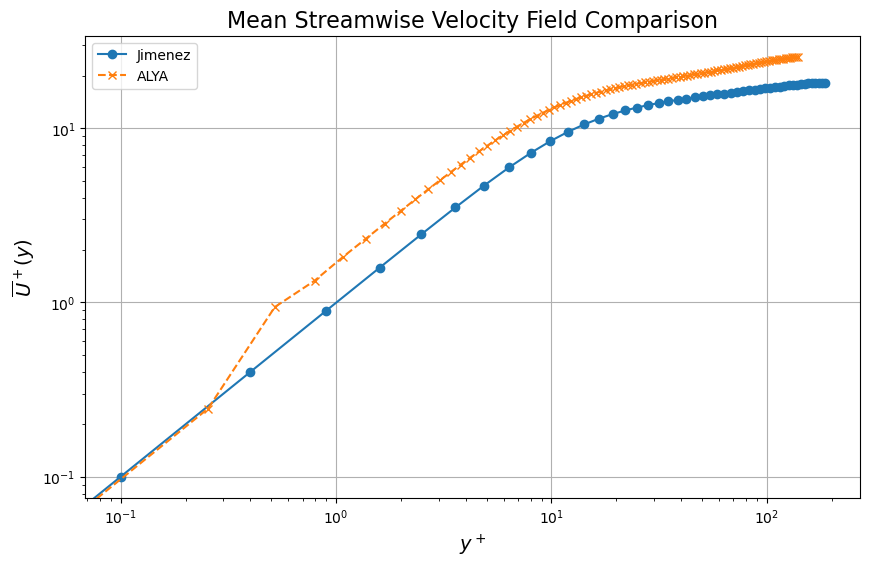

In [195]:
def plot_mean_streamwise_velocity(dataframe_jimenez, filtered_mean_velocities_normalized):
    """
    Plots the mean streamwise velocity field from two sources: Jimenez's dataset and filtered ALYA data.
    
    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "U+", etc.
    - filtered_mean_velocities_normalized (DataFrame): Contains averaged velocities such as "U_bar" indexed by "y".
    
    Both dataframes are expected to have appropriate columns for plotting the mean streamwise velocity against y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+'], dataframe_jimenez['U+'], label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    # Note: Converting 'y' to 'y+' for comparison purposes. Adjust this conversion as per actual data context.
    plt.plot(filtered_mean_velocities_normalized.index, filtered_mean_velocities_normalized['U_bar'], label='ALYA', marker='x', linestyle='--')
    
    # Setting the x-axis to logarithmic scale
    plt.xscale('log')
    plt.yscale('log')
    
    # Adding labels and title
    plt.xlabel('$y^+$', fontsize=14)
    plt.ylabel('$\overline{U}^+(y)$', fontsize=14)
    plt.title('Mean Streamwise Velocity Field Comparison', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()

# Example usage:
plot_mean_streamwise_velocity(dataframe_jimenez, filtered_mean_velocities_normalized)


## Root-mean-square velocity fluctuations 

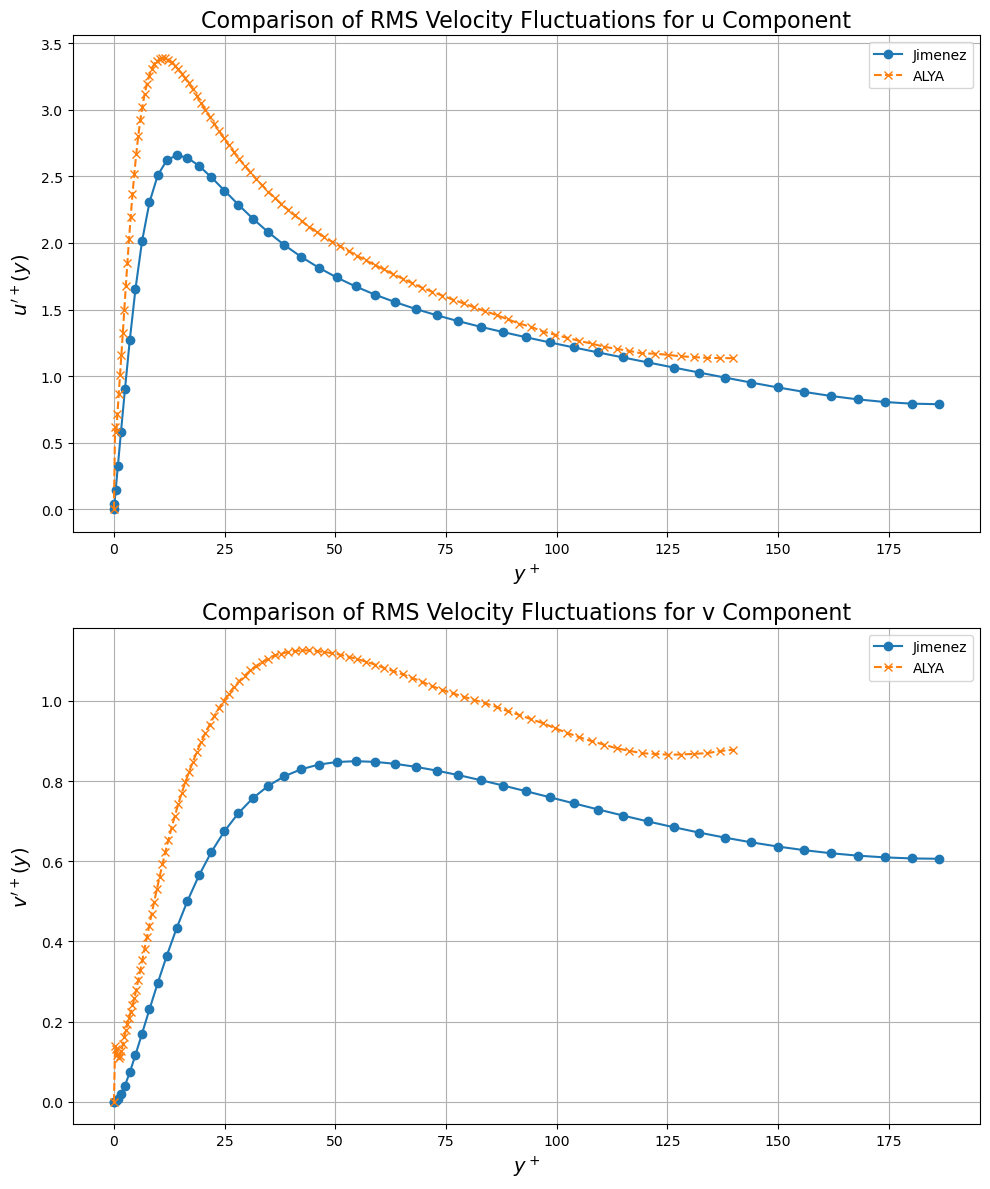

In [196]:
def plot_rms_velocity_fluctuations_uv(dataframe_jimenez, filtered_rms_velocities_normalized):
    """
    Plots the RMS velocity fluctuations for both the u and v components against the y-coordinate for data 
    from Jimenez and ALYA in two separate subplots.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "u'+", "v'+", etc.
    - filtered_rms_velocities_normalized (DataFrame): Contains ALYA data with columns such as "y", "u_prime", "v_prime".

    Both dataframes are expected to have appropriate columns for plotting the RMS velocity fluctuations against y-coordinate.
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot for u' RMS fluctuations
    ax1.plot(dataframe_jimenez['y+'], dataframe_jimenez["u'+"], label='Jimenez', marker='o', linestyle='-')
    ax1.plot(filtered_rms_velocities_normalized.index, filtered_rms_velocities_normalized['u_prime'], label='ALYA', marker='x', linestyle='--')
    #ax1.set_xscale('log')
    ax1.set_xlabel('$y^+$', fontsize=14)
    ax1.set_ylabel('$u\'^+(y)$', fontsize=14)
    ax1.set_title('Comparison of RMS Velocity Fluctuations for u Component', fontsize=16)
    ax1.legend()
    ax1.grid(True)

    # Plot for v' RMS fluctuations
    ax2.plot(dataframe_jimenez['y+'], dataframe_jimenez["v'+"], label='Jimenez', marker='o', linestyle='-')
    ax2.plot(filtered_rms_velocities_normalized.index, filtered_rms_velocities_normalized['v_prime'], label='ALYA', marker='x', linestyle='--')
    #ax2.set_xscale('log')
    ax2.set_xlabel('$y^+$', fontsize=14)
    ax2.set_ylabel('$v\'^+(y)$', fontsize=14)
    ax2.set_title('Comparison of RMS Velocity Fluctuations for v Component', fontsize=16)
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

# Example usage:
plot_rms_velocity_fluctuations_uv(dataframe_jimenez, filtered_rms_velocities_normalized)


Since the non-dimensionalization values differ, the comparisons are not accurate, and the intervals for the definition of \( y \), for example, do not align. Therefore, for a more accurate comparison, non-dimensionalized values will be used.

In [201]:
def plot_mean_streamwise_velocity_dim(dataframe_jimenez, filtered_mean_velocities_normalized):
    """
    Plots the mean streamwise velocity field from two sources: Jimenez's dataset and filtered ALYA data.
    
    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y", "U", etc.
    - filtered_mean_velocities_normalized (DataFrame): Contains averaged velocities such as "U_bar" indexed by "y".
    
    Both dataframes are expected to have appropriate columns for plotting the mean streamwise velocity against y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+']*delta_tau_jimenez, dataframe_jimenez['U+']*u_tau_jimenez, label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    # Note: Converting 'y' to 'y+' for comparison purposes. Adjust this conversion as per actual data context.
    plt.plot(filtered_mean_velocities_normalized.index*delta_tau, filtered_mean_velocities_normalized['U_bar']*u_tau, label='ALYA', marker='x', linestyle='--')
    
    # Setting the x-axis to logarithmic scale
    plt.xscale('log')
    plt.yscale('log')
    
    # Adding labels and title
    plt.xlabel('$y$', fontsize=14)
    plt.ylabel('$\overline{U}(y)$', fontsize=14)
    plt.title('Mean Streamwise Velocity Field Comparison', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()



In [205]:
def plot_rms_velocity_fluctuations_uv_dim(dataframe_jimenez, filtered_rms_velocities_normalized):
    """
    Plots the RMS velocity fluctuations for both the u and v components against the y-coordinate for data 
    from Jimenez and ALYA in two separate subplots.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y", "u'", "v'", etc.
    - filtered_rms_velocities_normalized (DataFrame): Contains ALYA data with columns such as "y", "u_prime", "v_prime".

    Both dataframes are expected to have appropriate columns for plotting the RMS velocity fluctuations against y-coordinate.
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot for u' RMS fluctuations
    ax1.plot(dataframe_jimenez['y+']*delta_tau_jimenez, dataframe_jimenez["u'+"]*u_tau_jimenez, label='Jimenez', marker='o', linestyle='-')
    ax1.plot(filtered_rms_velocities_normalized.index*delta_tau, filtered_rms_velocities_normalized['u_prime']*u_tau, label='ALYA', marker='x', linestyle='--')
    #ax1.set_xscale('log')
    ax1.set_xlabel('$y^+$', fontsize=14)
    ax1.set_ylabel('$u\'^+(y)$', fontsize=14)
    ax1.set_title('Comparison of RMS Velocity Fluctuations for u Component', fontsize=16)
    ax1.legend()
    ax1.grid(True)

    # Plot for v' RMS fluctuations
    ax2.plot(dataframe_jimenez['y+']*delta_tau_jimenez, dataframe_jimenez["v'+"]*u_tau_jimenez, label='Jimenez', marker='o', linestyle='-')
    ax2.plot(filtered_rms_velocities_normalized.index*delta_tau, filtered_rms_velocities_normalized['v_prime']*u_tau, label='ALYA', marker='x', linestyle='--')
    #ax2.set_xscale('log')
    ax2.set_xlabel('$y^+$', fontsize=14)
    ax2.set_ylabel('$v\'^+(y)$', fontsize=14)
    ax2.set_title('Comparison of RMS Velocity Fluctuations for v Component', fontsize=16)
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()


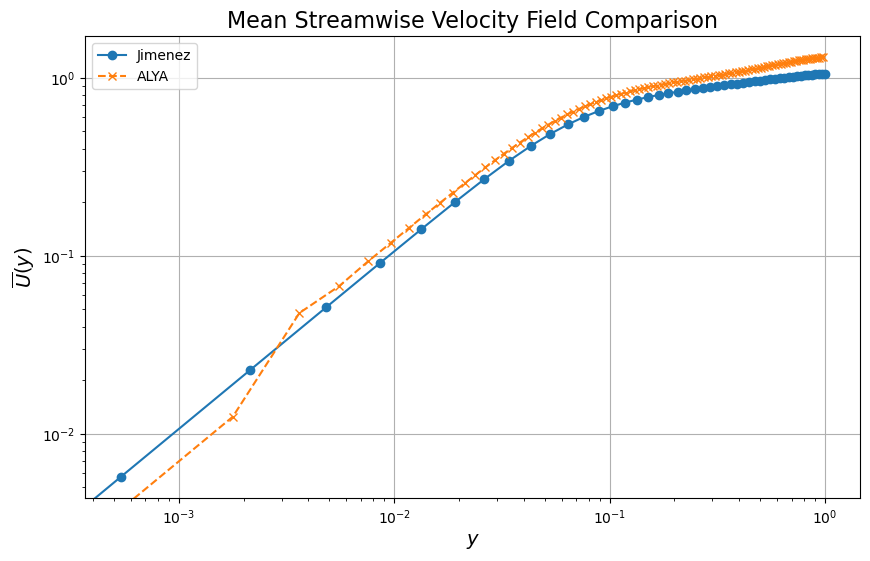

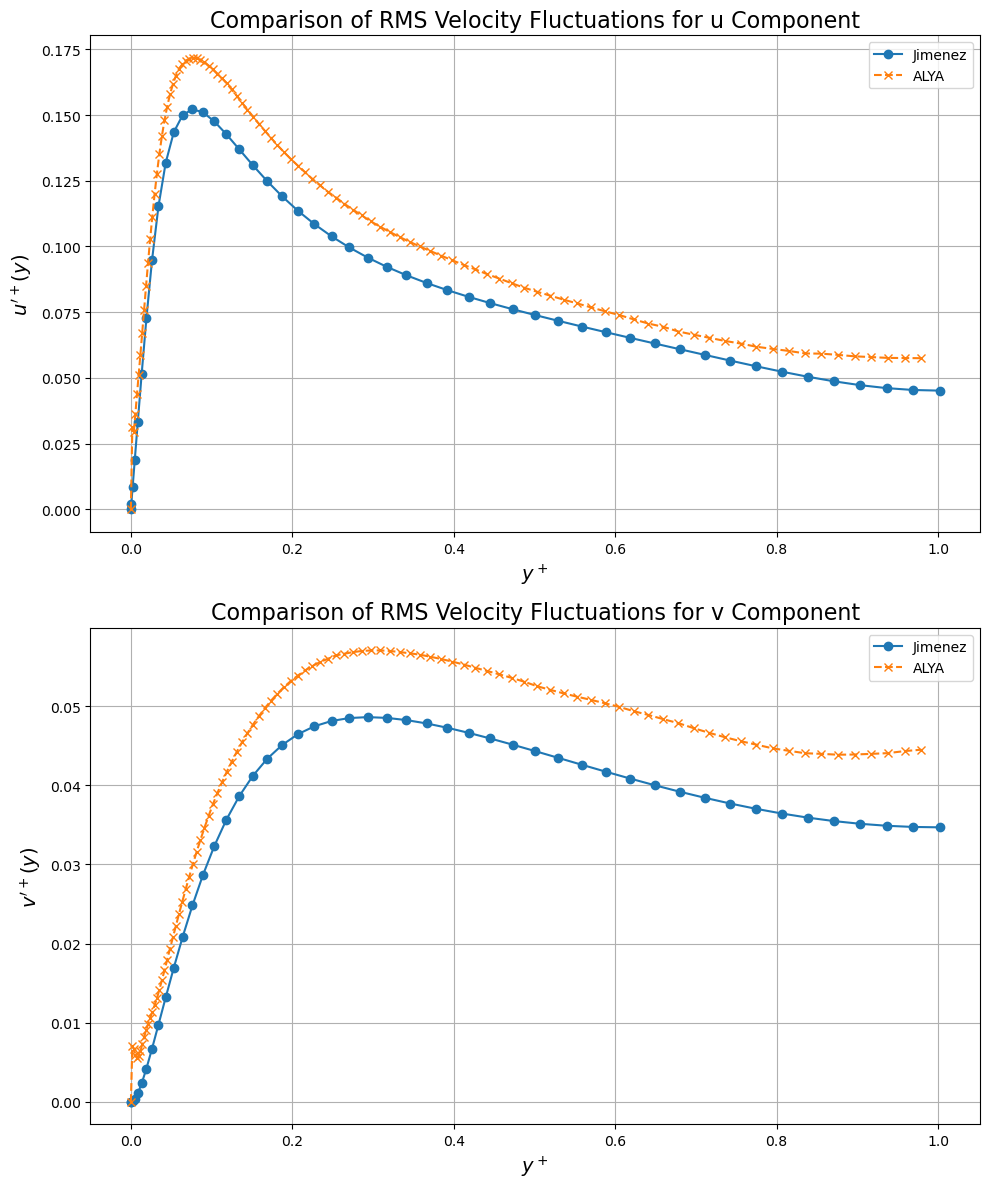

In [206]:
# Example usage:
plot_mean_streamwise_velocity_dim(dataframe_jimenez, filtered_mean_velocities_normalized)
plot_rms_velocity_fluctuations_uv_dim(dataframe_jimenez, filtered_rms_velocities_normalized)

The results indicate a discrepancy between the simulation outcomes using ALYA and the data from Jimenez. Several factors may account for this issue:

- The Reynolds number in the ALYA simulation is calculated to be 140, whereas Jimenez's data corresponds to a Reynolds number of 180. Given this difference, one would expect, for instance, a lower average value of $U$ in the ALYA simulation due to the lower Reynolds number. This suggests either an error in the calculation of the Reynolds number, specifically $u_\tau$, or another source of error.
- When examining the simulation with Paraview, it is observed that instabilities frequently form and are subsequently smoothed out by the simulation. These instabilities could naturally introduce errors into the statistical analysis.

At first glance, these instabilities could originate either from the code itself or from the chosen parameters. Still, it is interesting to look at the Reynolds stress, defined as:

$$
\tau_{uv} = -\langle uv \rangle
$$

where $\langle ... \rangle$ is the average over $x,z$ and $t$. 

## Reynolds shear stress

To compute the shear stress, it is necessary to reload the data because the calculation relies on the instantaneous velocity components $u$ and $v$, rather than the mean velocity $\overline{U}$ or the fluctuating components $u'$.

In [233]:
def load_data_and_give_shear_stress(directory, mean_velocities):
    """
    Loads PVTU files listed in a PVD file located in the given directory,
    calculates the RMS velocity components (u', v') across all timesteps,
    and returns a DataFrame with the shear stress (u'v') averaged over x and z coordinates.
    
    Parameters:
    - directory (str): Path to the directory containing the PVD and PVTU files.
    - mean_velocities (DataFrame): DataFrame containing the averaged velocities from 
      load_data_and_give_average_velocity(directory).

    Returns:
    - pd.DataFrame: DataFrame with the shear stress (u'v') for each y-coordinate.
    """
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel_after_transient.pvd')  # Not the full simulation, only points after the transition state
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    
    # Extract PVTU file paths from the PVD file
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize array for accumulating shear stress
    sum_uv = 0
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        
        # Extract velocity components
        u, v, _ = mesh['VELOC'].T
        
        # Create a DataFrame with the instantaneous velocities and coordinates
        df = pd.DataFrame({
            'x': mesh.points[:, 0],
            'y': mesh.points[:, 1],
            'z': mesh.points[:, 2],
            'u': u,
            'v': v,
        })
        
        # Merge with mean_velocities to get the mean velocity for each y
        df = df.merge(mean_velocities, on='y')
        
        # Calculate the velocity fluctuations
        df['u_fluc'] = df['u'] - df['U_bar']
        df['v_fluc'] = df['v'] - df['V_bar']
        
        # Accumulate the shear stress (u'v')
        sum_uv += df['u_fluc'] * df['v_fluc']
        
        count += 1
        # print(f"Data from {path} loaded and velocity components added.")  # Uncomment if you want to check the files loaded
    
    # Calculate the mean shear stress over time
    uv = sum_uv / count
    
    # Create a DataFrame with the shear stress data
    data_t_rms = pd.DataFrame({
        'x': mesh.points[:, 0],
        'y': mesh.points[:, 1],
        'z': mesh.points[:, 2],
        'uv_t': uv,
    })
    
    print(f"Total data sets processed: {count}")

    # Calculate mean shear stress over x and z for each y
    shear_stress = data_t_rms.groupby('y').agg({
        'uv_t': 'mean'
    })
    
    # Rename columns for clarity
    shear_stress.columns = ['uv']
    
    return shear_stress



In [249]:
def normalize_shear_stress(shear_stress, u_tau, delta_tau):
    """
    Normalizes the shear stress and the y-coordinate.
    
    Parameters:
    - shear_stress (DataFrame): DataFrame containing the shear stress data.
    - u_tau (float): Friction velocity.
    - delta_tau (float): Characteristic length scale.

    Returns:
    - pd.DataFrame: Normalized shear stress and y-coordinate.
    """
    # Normalize the shear stress component
    shear_stress_normalized = shear_stress.copy()
    shear_stress_normalized['uv'] /= (u_tau ** 2)

    # Normalize the y-coordinate in the DataFrame
    shear_stress_normalized['y'] = shear_stress_normalized.index/ delta_tau
    shear_stress_normalized.set_index('y', inplace=True)

    return shear_stress_normalized


In [250]:
#shear_stress = load_data_and_give_shear_stress(directory_path, mean_velocities)
shear_stress_normalized = normalize_shear_stress(shear_stress, u_tau, delta_tau)
filtered_shear_stress_normalized = filter_data_by_y(shear_stress_normalized, y_min, y_max)

In [251]:
def plot_reynolds_shear_stress(dataframe_jimenez, shear_stress_normalized):
    """
    Plots the Reynolds shear stress against the y-coordinate for data from Jimenez and ALYA.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "uv'+", etc.
    - shear_stress_normalized (DataFrame): Contains ALYA data with columns such as "uv" indexed by "y".

    Both dataframes are expected to have appropriate columns for plotting the Reynolds shear stress against the y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+'], -dataframe_jimenez["uv'+"], label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    plt.plot(shear_stress_normalized.index, -shear_stress_normalized['uv']/u_tau, label='ALYA', marker='x', linestyle='--')
    
    # Adding labels and title
    plt.xlabel('$y^+$', fontsize=14)
    plt.ylabel('$-u\'v\'^+(y)$', fontsize=14)
    plt.title('Comparison of Reynolds Shear Stress', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()




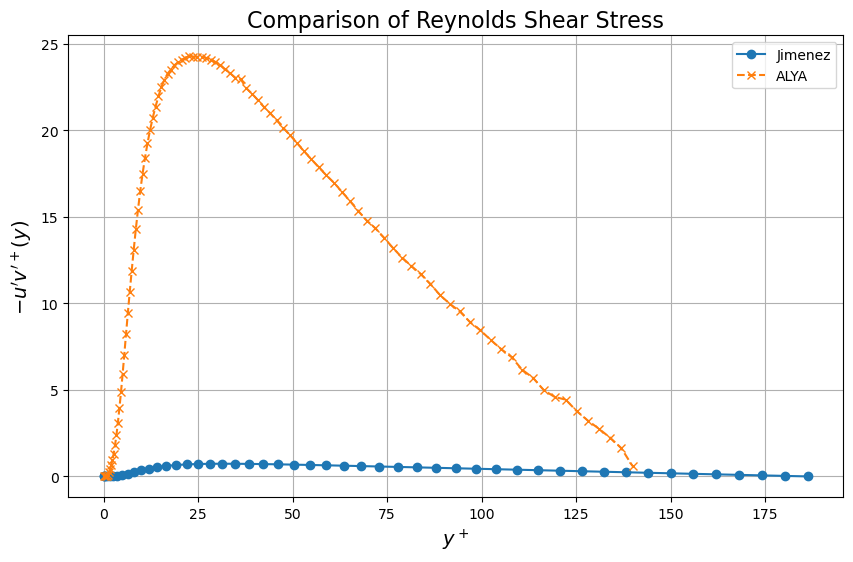

In [252]:
plot_reynolds_shear_stress(dataframe_jimenez, filtered_shear_stress_normalized)

Similar to previous cases, it is preferable to compare non-dimensionless values in this specific instance.

In [254]:
def plot_reynolds_shear_stress_dim(dataframe_jimenez, shear_stress_normalized):
    """
    Plots the Reynolds shear stress against the y-coordinate for data from Jimenez and ALYA.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "uv'+", etc.
    - shear_stress_normalized (DataFrame): Contains ALYA data with columns such as "uv" indexed by "y".

    Both dataframes are expected to have appropriate columns for plotting the Reynolds shear stress against the y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+']*delta_tau_jimenez, -dataframe_jimenez["uv'+"]*(u_tau_jimenez**2), label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    plt.plot(shear_stress_normalized.index*delta_tau, -shear_stress_normalized['uv']*(u_tau**2), label='ALYA', marker='x', linestyle='--')
    
    # Adding labels and title
    plt.xlabel('$y$', fontsize=14)
    plt.ylabel('$-uv(y)$', fontsize=14)
    plt.title('Comparison of Reynolds Shear Stress', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()




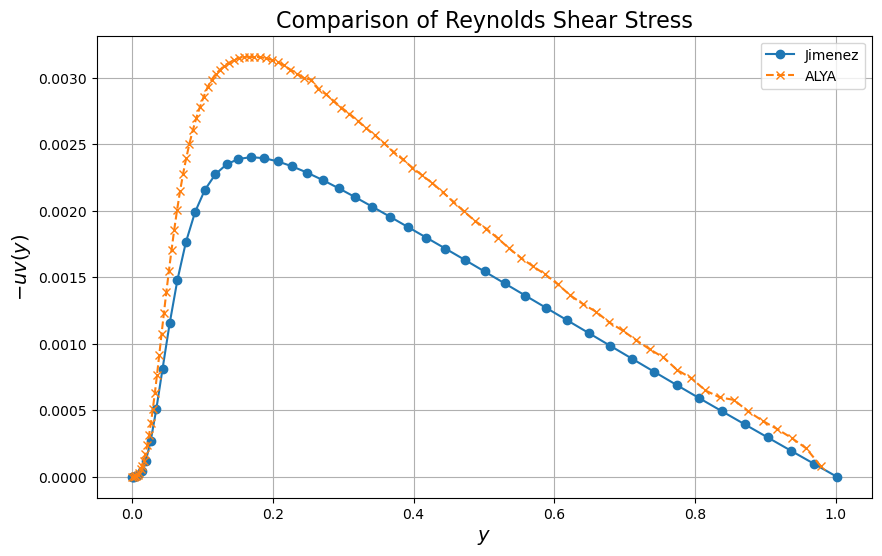

In [255]:
plot_reynolds_shear_stress_dim(dataframe_jimenez, filtered_shear_stress_normalized)

As before, the trend is good, but the values are incorrect.

# Finding the Errors

To identify the errors, statistics will be examined in a small portion of the simulation where the images from ParaView appear accurate.

In [6]:
def load_data_and_give_average_velocity(directory):
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel_trie.pvd') # Not the full simulation, only the points after the transition state
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize arrays for accumulating data
    sum_u, sum_v, sum_w = 0, 0, 0
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        # Accumulate the velocity components
        u, v, w = mesh['VELOC'].T
        sum_u += u
        sum_v += v
        sum_w += w
        
        count += 1
        # print(f"Data from {path} loaded and velocity components added.") # If you want to check the files loaded
    
    # Calculate the average of the velocity components
    avg_u = sum_u / count
    avg_v = sum_v / count
    avg_w = sum_w / count
    
    # Get the spatial coordinates (assuming they are the same for all files)
    points = mesh.points  # x, y, z coordinates
    
    # Create a DataFrame with the averaged data
    data_t_avg = pd.DataFrame({
        'x': points[:, 0],
        'y': points[:, 1],
        'z': points[:, 2],
        'U_t_avg': avg_u,
        'V_t_avg': avg_v,
        'W_t_avg': avg_w
    })
    
    print(f"Total data sets processed: {count}")

    # Calculate mean over x and z for u, v, w 
    data_avg = data_t_avg.groupby('y').agg({
        'U_t_avg': ['mean'],
        'V_t_avg': ['mean'],
        'W_t_avg': ['mean']
    }).rename(columns={'mean': 'bar'}, level=1)
    data_avg.columns = ['U_bar', 'V_bar', 'W_bar']  # Clear column names
    
    return data_avg


In [7]:
# Last directory
directory_path = Path('/Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Last_long_run_22_06/vtk')

mean_velocities = load_data_and_give_average_velocity(directory_path)

Total data sets processed: 20


In [ ]:
def load_data_and_give_RMS_velocity(directory, mean_velocities):
    """
    This function loads PVTU files listed in a PVD file located in the given directory,
    calculates the RMS velocity components (u', v', w') across all timesteps, 
    and returns a DataFrame with the RMS velocity components averaged over x and z coordinates.
    
    Parameters:
    directory (str): Path to the directory containing the PVD and PVTU files.
    avg_velocities : Averaged velocity from load_data_and_give_average_velocity(directory)

    Returns:
    pd.DataFrame: DataFrame with RMS velocity components for each y-coordinate.
    """
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel_after_transient.pvd') # Not the full simulation, only the points after the transition state
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    
    # Extract PVTU file paths from the PVD file
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize arrays for accumulating squared velocity fluctuations
    sum_u2, sum_v2, sum_w2 = 0, 0, 0
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        
        # Extract velocity components
        u, v, w = mesh['VELOC'].T
        
        # Create a DataFrame with the instantaneous velocities and coordinates
        df = pd.DataFrame({
            'x': mesh.points[:, 0],
            'y': mesh.points[:, 1],
            'z': mesh.points[:, 2],
            'u': u,
            'v': v,
            'w': w
        })
        
        # Merge with data_avg to get the mean velocity for each y
        df = df.merge(mean_velocities, on='y')
        
        # Calculate the velocity fluctuations
        df['u_fluc'] = df['u'] - df['U_bar']
        df['v_fluc'] = df['v'] - df['V_bar']
        df['w_fluc'] = df['w'] - df['W_bar']
        
        # Accumulate the squared velocity fluctuations
        sum_u2 += df['u_fluc']**2
        sum_v2 += df['v_fluc']**2
        sum_w2 += df['w_fluc']**2
        
        count += 1
        # print(f"Data from {path} loaded and velocity components added.")  # Uncomment if you want to check the files loaded
    
    # Calculate the RMS of the velocity fluctuations
    rms_u = (sum_u2 / count)**0.5
    rms_v = (sum_v2 / count)**0.5
    rms_w = (sum_w2 / count)**0.5
    
    # Create a DataFrame with the RMS data
    data_t_rms = pd.DataFrame({
        'x': mesh.points[:, 0],
        'y': mesh.points[:, 1],
        'z': mesh.points[:, 2],
        'u_prime_t_rms': rms_u,
        'v_prime_t_rms': rms_v,
        'w_prime_t_rms': rms_w
    })
    
    print(f"Total data sets processed: {count}")

    # Calculate mean over x and z for u', v', w'
    rms_velocities = data_t_rms.groupby('y').agg({
        'u_prime_t_rms': 'mean',
        'v_prime_t_rms': 'mean',
        'w_prime_t_rms': 'mean'
    })
    
    # Rename columns for clarity
    rms_velocities.columns = ['u_prime', 'v_prime', 'w_prime']
    
    return rms_velocities


In [8]:
def filter_data_by_y(data, y_min, y_max):
    """
    Filters rows from a DataFrame based on the y-coordinate falling within a specified range.

    Parameters:
    - data (DataFrame): The DataFrame to filter, which must include 'y' as an index.
    - y_min (float): The minimum y-coordinate value to include in the filter.
    - y_max (float): The maximum y-coordinate value to include in the filter.

    Returns:
    - filtered_data (DataFrame): A DataFrame containing only the rows where the 'y' value is
      between y_min and y_max, inclusive.
    """
    # Filter the DataFrame to include only the rows where the index 'y' is between y_min and y_max
    filtered_data = data[(data.index >= y_min) & (data.index <= y_max)]
    
    return filtered_data

In [9]:
# Application

y_min = 0.0  # Define the minimum y-coordinate
y_max = 1.0  # Define the maximum y-coordinate
filtered_mean_velocities = filter_data_by_y(mean_velocities, y_min, y_max)

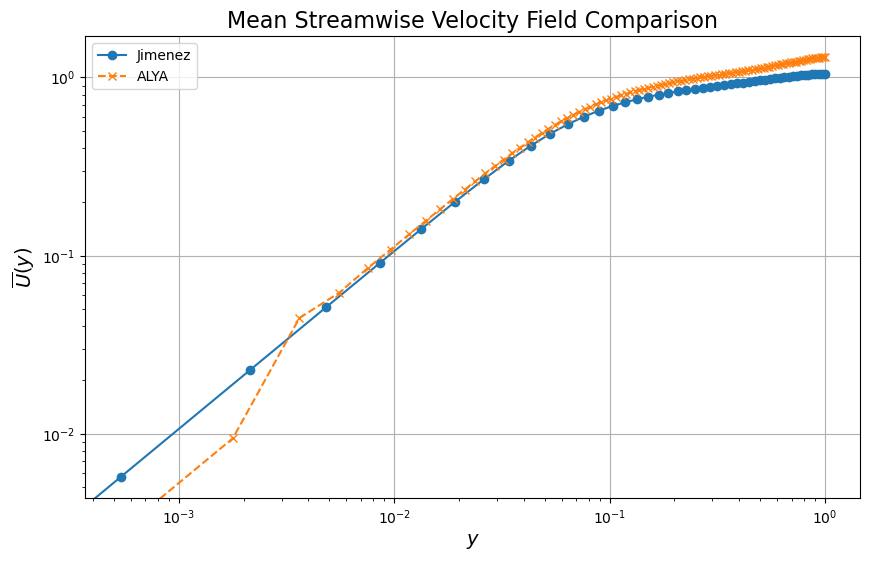

In [17]:
def plot_mean_streamwise_velocity(dataframe_jimenez, filtered_mean_velocities_normalized):
    """
    Plots the mean streamwise velocity field from two sources: Jimenez's dataset and filtered ALYA data.
    
    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "U+", etc.
    - filtered_mean_velocities_normalized (DataFrame): Contains averaged velocities such as "U_bar" indexed by "y".
    
    Both dataframes are expected to have appropriate columns for plotting the mean streamwise velocity against y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+']*delta_tau_jimenez, dataframe_jimenez['U+']*u_tau_jimenez, label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    # Note: Converting 'y' to 'y+' for comparison purposes. Adjust this conversion as per actual data context.
    plt.plot(filtered_mean_velocities_normalized.index, filtered_mean_velocities_normalized['U_bar'], label='ALYA', marker='x', linestyle='--')
    
    # Setting the x-axis to logarithmic scale
    plt.xscale('log')
    plt.yscale('log')
    
    # Adding labels and title
    plt.xlabel('$y$', fontsize=14)
    plt.ylabel('$\overline{U}(y)$', fontsize=14)
    plt.title('Mean Streamwise Velocity Field Comparison', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()

# Example usage:
plot_mean_streamwise_velocity(dataframe_jimenez, filtered_mean_velocities)


It can be observed that there is an improvement, but the velocity is still too high compared to the associated Reynolds number, and there are some issues with the small coordinates. It remains useful to examine the other statistics.

In [166]:
def load_data_and_give_RMS_velocity(directory, mean_velocities):
    """
    This function loads PVTU files listed in a PVD file located in the given directory,
    calculates the RMS velocity components (u', v', w') across all timesteps, 
    and returns a DataFrame with the RMS velocity components averaged over x and z coordinates.
    
    Parameters:
    directory (str): Path to the directory containing the PVD and PVTU files.
    avg_velocities : Averaged velocity from load_data_and_give_average_velocity(directory)

    Returns:
    pd.DataFrame: DataFrame with RMS velocity components for each y-coordinate.
    """
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel_trie.pvd') # Not the full simulation, only the points after the transition state
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    
    # Extract PVTU file paths from the PVD file
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize arrays for accumulating squared velocity fluctuations
    sum_u2, sum_v2, sum_w2 = 0, 0, 0
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        
        # Extract velocity components
        u, v, w = mesh['VELOC'].T
        
        # Create a DataFrame with the instantaneous velocities and coordinates
        df = pd.DataFrame({
            'x': mesh.points[:, 0],
            'y': mesh.points[:, 1],
            'z': mesh.points[:, 2],
            'u': u,
            'v': v,
            'w': w
        })
        
        # Merge with data_avg to get the mean velocity for each y
        df = df.merge(mean_velocities, on='y')
        
        # Calculate the velocity fluctuations
        df['u_fluc'] = df['u'] - df['U_bar']
        df['v_fluc'] = df['v'] - df['V_bar']
        df['w_fluc'] = df['w'] - df['W_bar']
        
        # Accumulate the squared velocity fluctuations
        sum_u2 += df['u_fluc']**2
        sum_v2 += df['v_fluc']**2
        sum_w2 += df['w_fluc']**2
        
        count += 1
        # print(f"Data from {path} loaded and velocity components added.")  # Uncomment if you want to check the files loaded
    
    # Calculate the RMS of the velocity fluctuations
    rms_u = (sum_u2 / count)**0.5
    rms_v = (sum_v2 / count)**0.5
    rms_w = (sum_w2 / count)**0.5
    
    # Create a DataFrame with the RMS data
    data_t_rms = pd.DataFrame({
        'x': mesh.points[:, 0],
        'y': mesh.points[:, 1],
        'z': mesh.points[:, 2],
        'u_prime_t_rms': rms_u,
        'v_prime_t_rms': rms_v,
        'w_prime_t_rms': rms_w
    })
    
    print(f"Total data sets processed: {count}")

    # Calculate mean over x and z for u', v', w'
    rms_velocities = data_t_rms.groupby('y').agg({
        'u_prime_t_rms': 'mean',
        'v_prime_t_rms': 'mean',
        'w_prime_t_rms': 'mean'
    })
    
    # Rename columns for clarity
    rms_velocities.columns = ['u_prime', 'v_prime', 'w_prime']
    
    return rms_velocities


In [167]:
rms_velocities = load_data_and_give_RMS_velocity(directory_path, mean_velocities)
mean_velocities_normalized, rms_velocities_normalized, u_tau, delta_tau = normalize_data(mean_velocities, rms_velocities, nu)
filtered_rms_velocities_normalized = filter_data_by_y(rms_velocities_normalized, y_min, y_max)

Total data sets processed: 20
Calculated u_tau: 0.057231059
Calculated delta_tau: 0.005376316864804261


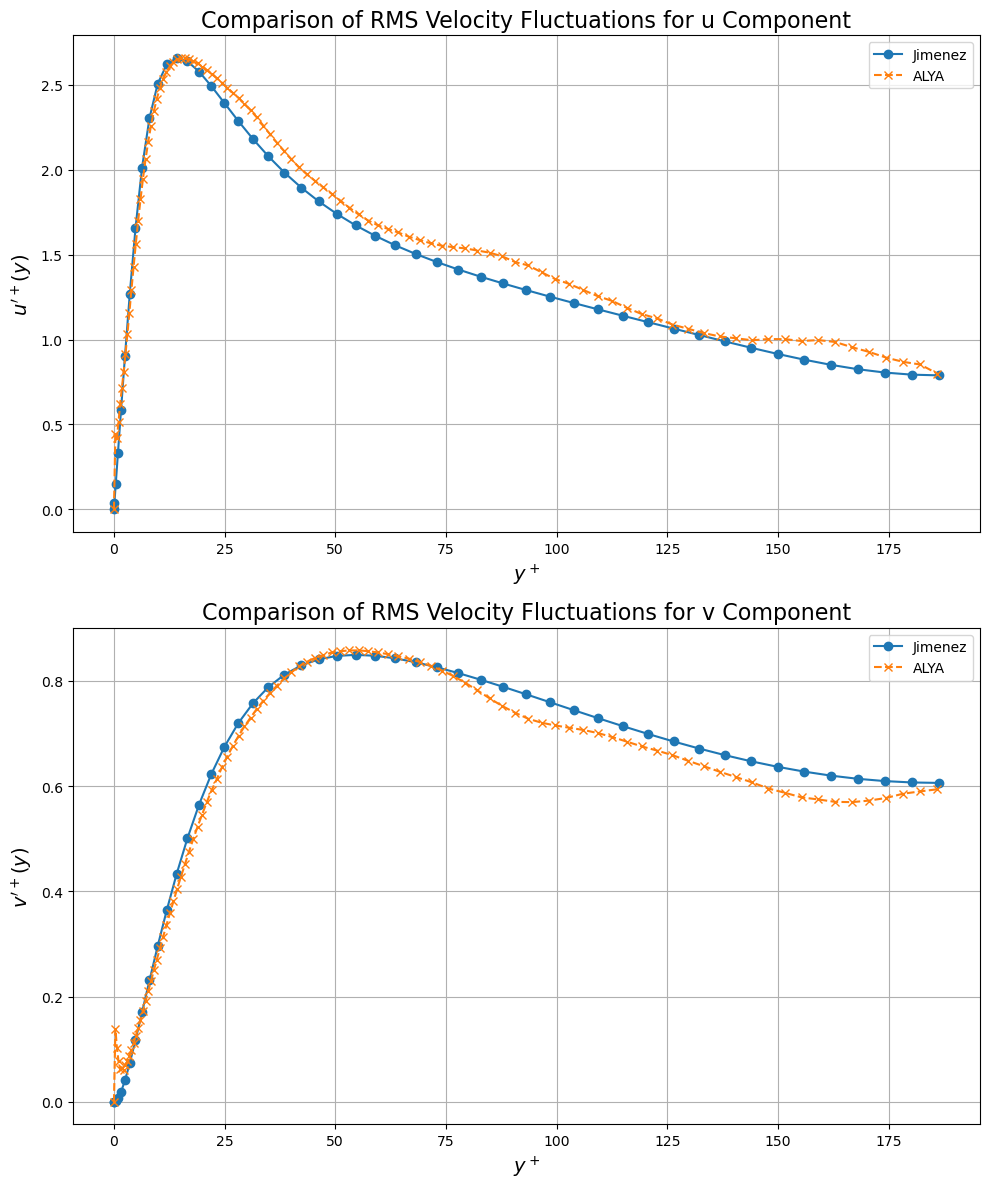

In [168]:
def plot_rms_velocity_fluctuations_uv(dataframe_jimenez, filtered_rms_velocities_normalized):
    """
    Plots the RMS velocity fluctuations for both the u and v components against the y-coordinate for data 
    from Jimenez and ALYA in two separate subplots.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "u'+", "v'+", etc.
    - filtered_rms_velocities_normalized (DataFrame): Contains ALYA data with columns such as "y", "u_prime", "v_prime".

    Both dataframes are expected to have appropriate columns for plotting the RMS velocity fluctuations against y-coordinate.
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot for u' RMS fluctuations
    ax1.plot(dataframe_jimenez['y+'], dataframe_jimenez["u'+"], label='Jimenez', marker='o', linestyle='-')
    ax1.plot(filtered_rms_velocities_normalized.index, filtered_rms_velocities_normalized['u_prime'], label='ALYA', marker='x', linestyle='--')
    #ax1.set_xscale('log')
    ax1.set_xlabel('$y^+$', fontsize=14)
    ax1.set_ylabel('$u\'^+(y)$', fontsize=14)
    ax1.set_title('Comparison of RMS Velocity Fluctuations for u Component', fontsize=16)
    ax1.legend()
    ax1.grid(True)

    # Plot for v' RMS fluctuations
    ax2.plot(dataframe_jimenez['y+'], dataframe_jimenez["v'+"], label='Jimenez', marker='o', linestyle='-')
    ax2.plot(filtered_rms_velocities_normalized.index, filtered_rms_velocities_normalized['v_prime'], label='ALYA', marker='x', linestyle='--')
    #ax2.set_xscale('log')
    ax2.set_xlabel('$y^+$', fontsize=14)
    ax2.set_ylabel('$v\'^+(y)$', fontsize=14)
    ax2.set_title('Comparison of RMS Velocity Fluctuations for v Component', fontsize=16)
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

# Example usage:
plot_rms_velocity_fluctuations_uv(dataframe_jimenez, filtered_rms_velocities_normalized)
